# Differential Privacy

Python 3.9

In [3]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
data = pd.read_csv(os.path.join('dataset', 'infringement_dataset.csv'))
data = data.dropna()

In [5]:
data.head()

,loan_id,infringed,contract_type,gender,has_own_car,has_own_realty,num_children,annual_income,credit_amount,credit_annuity,...,SK_ID_CURR,avg_days_decision,past_avg_amount_annuity,past_avg_amt_application,past_avg_amt_credit,past_loans_approved,past_loans_refused,past_loans_canceled,past_loans_unused,past_loans_total
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,100002.0,606.000000,9251.775,179055.00,179055.00,1.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,100003.0,1305.000000,56553.990,435436.50,484191.00,3.0,0.0,0.0,0.0,3.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,100004.0,815.000000,5357.250,24282.00,20106.00,1.0,0.0,0.0,0.0,1.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,100006.0,272.444444,23651.175,272203.26,291695.50,5.0,3.0,1.0,0.0,9.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,100007.0,1222.833333,12278.805,150530.25,166638.75,6.0,0.0,0.0,0.0,6.0


## functions

In [54]:
def calculate_sensitivity(data, function):
    data = data.to_numpy()
    results = []
    for i in range(len(data)):
        array_prev = data[:i]
        array_pos = data[i+1:]
        data_without = np.concatenate((array_prev, array_pos), axis=None)
        res = np.abs(function(data) - (function(data_without)))
        results.append(res)
    
    return np.max(np.array(results))

In [55]:
def add_noise(data, sensitivity, epsilon):
    return data + np.random.laplace(loc=0, scale=sensitivity/epsilon)

In [56]:
def error(original, predicted):
    return (original - predicted) / original * 100

In [57]:
def count_total (epsilon, infringed=True):
    count = data[data.infringed == infringed].shape[0]
    res = add_noise(count, calculate_sensitivity(data.infringed, len), epsilon)
    print(f"Percentage error: {np.abs(error(count, res))} %")
    return res

In [58]:
def average(variable, infringed=True, epsilon=0.01):
    selected_data = data[data.infringed == infringed][variable]
    mean = selected_data.mean()
    sens1 = calculate_sensitivity(selected_data, np.sum)
    sens2 = calculate_sensitivity(selected_data, len)
    res = add_noise(selected_data.sum(), sens1, epsilon) / add_noise(selected_data.shape[0], sens2, epsilon)
    print(f"Percentage error: {np.abs(error(mean, res))} %")
    return res

## Analysis - 1

### Average age of of people who infringed and don't

In [63]:
def average_age(infringed=True, epsilon=0.01):
    return average('age', infringed, epsilon)

In [64]:
print('Mean age of the people who infringed', average_age())
print('Mean age of the people who not infringed', average_age(infringed=False))

Percentage error: 0.16054592831314604 %
Mean age of the people who infringed 40.21529188277272
Percentage error: 0.03205750118189382 %
Mean age of the people who not infringed 43.699110059813194


### Percentage poeple < 35

In [50]:
def number_people_by_age(condition, infringed=True, epsilon=0.01):
    selected_data = data.query(f'age {condition} & infringed == {infringed}')['age']
    data_count = len(selected_data)
    sensitivity = 1
    res = add_noise(data_count, calculate_sensitivity(selected_data, len), epsilon) / count_total(epsilon, infringed) * 100
    print(f"Percentage error: {np.abs(error(data_count, res))} %")
    return res

In [88]:
less_35_infringed = number_people_by_age('<35')
less_35_not_infringed = number_people_by_age('<35', infringed=False)
print(f'Percentage people < 35 that infringed', less_35_infringed, '%')
print(f'Percentage people < 35 that not infringed', less_35_not_infringed, '%')

Percentage error: 0.03737639520234489 %
Percentage error: 99.60046257671958 %
Percentage error: 0.016445473876584873 %
Percentage error: 99.96464559452876 %
Percentage people < 35 that infringed 36.80538743259325 %
Percentage people < 35 that not infringed 26.596058603836763 %


### Number people > 60

In [89]:
over_60_infringed = number_people_by_age('>60')
over_60_not_infringed = number_people_by_age('>60', infringed=False)

Percentage error: 0.8839908297550622 %
Percentage error: 99.58227493129677 %
Percentage error: 0.0035080465811559935 %
Percentage error: 99.96458699295384 %


In [90]:
print(f'Number people >60 that infringed', over_60_infringed)
print(f'Number people >60 that not infringed', over_60_not_infringed)

Number people >60 that infringed 6.036127242761748
Number people >60 that not infringed 9.888373957500987


In [91]:
between_infringed = 100 - over_60_infringed - less_35_infringed
between_not_infringed = 100 - over_60_not_infringed - less_35_not_infringed

([<matplotlib.patches.Wedge at 0x2102ef87730>,
 [Text(0.44302664828761695, 1.0068402996041828, '<35'),
  Text(-0.6248702564593822, -0.9052829185356288, '35-60'),
  Text(1.0802813905646138, -0.2073454055429836, '>60')],
 [Text(0.24165089906597287, 0.5491856179659178, '36.8%'),
  Text(-0.3408383217051176, -0.4937906828376157, '57.2%'),
  Text(0.5892443948534257, -0.1130974939325365, '6.0%')])

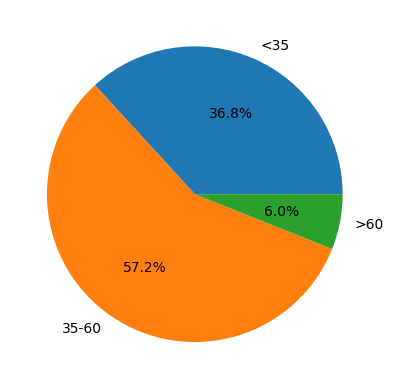

In [92]:
plt.pie([less_35_infringed, between_infringed, over_60_infringed], labels=['<35', '35-60', '>60'], autopct='%1.1f%%')

### Average credit amount

In [93]:
def average_credit_amount(infringed=True, epsilon=0.01):
    return average('credit_amount', infringed, epsilon)

In [94]:
print('Average credit amount of people who infringed', average_credit_amount())
print('Average credit amount of people who not infringed', average_credit_amount(False))

Percentage error: 6.1624240055071615 %
Average credit amount of people who infringed 592151.2055606454
Percentage error: 0.9280605330485149 %
Average credit amount of people who not infringed 608241.2228602935


### Average annual income

In [95]:
def average_income(infringed=True, epsilon=0.01):
    return average('annual_income',infringed, epsilon)

In [96]:
print('Average income of people who infringed', average_income())
print('Average income of people who not infringed', average_income(False))

Percentage error: 111.69963080390927 %
Average income of people who infringed 350599.4864065841
Percentage error: 2.6858824137881325 %
Average income of people who not infringed 164536.49345784672


### Average number family members

In [31]:
def average_family_members(infringed=True, epsilon=0.01):
    return average('num_family_members', infringed, epsilon)

In [33]:
print('Average no.family members of people who infringed', average_family_members())
print('Average no.family members  of people who not infringed', average_family_members(False))

Percentage error: 22.22199978720579 %
Average no.family members of people who infringed 1.897250124181677
Percentage error: 0.4256272836589865 %
Average no.family members  of people who not infringed 2.473808530314866


### Percentage female and male who requested loans

https://becominghuman.ai/query-sensitivity-types-and-effects-on-differential-privacy-mechanism-c94fd14b9837

In [103]:
def count_by_gender(infringed=True, epsilon=0.01):
    females = data[(data.gender == 'F') & (data.infringed == infringed)]
    males = data[(data.gender == 'M') & (data.infringed == infringed)]
    count_females = females.shape[0]
    count_males = males.shape[0]
    res_female = add_noise(count_females, calculate_sensitivity(females, len), epsilon) / count_total(epsilon, infringed) * 100
    res_male = add_noise(count_males, calculate_sensitivity(males, len), epsilon) / count_total(epsilon, infringed) * 100

    return res_female, res_male

In [104]:
f, m = count_by_gender()
print(f'Number of females who made loans and were infringed', f)
print(f'Number of males who made loans and were infringed', m)
f, m = count_by_gender(False)
print(f'Number of females who made loans and werent infringed', f)
print(f'Number of males who made loans and werent infringed', m)

Percentage error: 1.2390668883849727 %
Percentage error: 0.03547338678345388 %
Number of females who made loans and were infringed 55.644271288144424
Number of males who made loans and were infringed 44.72973811069526
Percentage error: 0.0015647190162784788 %
Percentage error: 0.04183861598191345 %
Number of females who made loans and werent infringed 66.62537666338713
Number of males who made loans and werent infringed 33.39252091823837


## Analysis 2 - According to past values

### Average loans 

In [34]:
def average_past_loans(infringed=True, epsilon=0.01):
    return average('past_loans_total', infringed, epsilon)

In [35]:
print('Average loans of people who infringed', average_past_loans())
print('Average loans of people who not infringed', average_past_loans(False))

Percentage error: 11.084137808251663 %
Average loans of people who infringed 4.8397991433833125
Percentage error: 5.270399795126464 %
Average loans of people who not infringed 4.724761834604171


### Average loans approved

In [36]:
def average_loans_approved(infringed=True, epsilon=0.01):
    return average('past_loans_approved', infringed, epsilon)

In [40]:
print('Average loans approved of people who infringed', average_loans_approved())
print('Average loans approved of people who not infringed', average_loans_approved(False))

Percentage error: 23.940452927771112 %
Average loans approved of people who infringed 3.7040557064896467
Percentage error: 0.5045331154146948 %
Average loans approved of people who not infringed 3.207386403414266


### Average loans refused

In [41]:
def average_loans_refused(infringed=True, epsilon=0.01):
    return average('past_loans_refused', infringed, epsilon)

In [42]:
print('Average loans refused of people who infringed', average_loans_refused())
print('Average loans refused of people who not infringed', average_loans_refused(False))

Percentage error: 77.39782565095018 %
Average loans refused of people who infringed 0.22096556931436617
Percentage error: 9.510519207962997 %
Average loans refused of people who not infringed 0.8558327556573528


### Average amount annuity in past loans

In [43]:
def average_loans_amount_annuity(infringed=True, epsilon=0.01):
    return average('past_avg_amount_annuity', infringed, epsilon)

In [44]:
print('Average loans amount annuity of people who infringed', average_loans_amount_annuity())
print('Average loans ammount annuity of people who not infringed', average_loans_amount_annuity(False))

Percentage error: 8.37376360978757 %
Average loans amount annuity of people who infringed 13399.447176371625
Percentage error: 1.3934740993777963 %
Average loans ammount annuity of people who not infringed 15638.204246710224


### Average amount application

In [45]:
def average_loans_amount_application(infringed=True, epsilon=0.01):
    return average('past_avg_amt_application', infringed, epsilon)

In [46]:
print('Average loans amount application of people who infringed', average_loans_amount_application())
print('Average loans ammount application of people who not infringed', average_loans_amount_application(False))

Percentage error: 48.02270859993485 %
Average loans amount application of people who infringed 236824.3018215088
Percentage error: 16.489181089781194 %
Average loans ammount application of people who not infringed 194098.93886207265


### Average loans canceled

In [64]:
def average_loans_canceled(infringed=True, epsilon=0.01):
    return average('past_loans_canceled', infringed, epsilon)

In [68]:
print('Average loans canceled of people who infringed', average_loans_canceled())
print('Average loans canceled of people who not infringed', average_loans_canceled(False))

Percentage error: 49.751656054557884 %
Average loans canceled of people who infringed 0.6720506734254752
Percentage error: 46.77121852018704 %
Average loans canceled of people who not infringed 1.2861032657986993
